## Reading parquet using dask


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

import dask
import dask.dataframe as dd
import dask.array as da
from dask.distributed import Client
from dask import delayed
import joblib

client = Client(processes=True) # use all 4 cores
client.connection_args


def collate_dask_df(device, sensor):

    """
        Function that returns a single dask dataframe from multiple text files hosted on github
        
        Parameters
        ----------
        
        device: str
            type of the device: ['phone', 'watch']

        sensor: str
            type of the sensor: ['accel', 'gyro']
        
    """
    

    base_url = './data/parquet'
    file_names = [f'/data_{user_id}_{sensor}_{device}.gzip' for user_id in range(1600, 1651)]
    loop_urls = [base_url + "/" + device + "/" + sensor + file_name for file_name in file_names]
    dask_df = dd.read_parquet(loop_urls, index='index')
    
    return dask_df 




2022-06-01 04:20:44,495 - distributed.diskutils - INFO - Found stale lock file and directory '/home/work/dask-worker-space/worker-4aiml42l', purging
2022-06-01 04:20:44,515 - distributed.diskutils - INFO - Found stale lock file and directory '/home/work/dask-worker-space/worker-6ei97x1k', purging
2022-06-01 04:20:44,535 - distributed.diskutils - INFO - Found stale lock file and directory '/home/work/dask-worker-space/worker-azcvt65o', purging
2022-06-01 04:20:44,583 - distributed.diskutils - INFO - Found stale lock file and directory '/home/work/dask-worker-space/worker-zhmug6_q', purging


In [2]:
%%time
dd_ref = {
    'phone_accel': collate_dask_df('phone', 'accel'),
    'phone_gyro': collate_dask_df('phone', 'gyro'),
    'watch_accel': collate_dask_df('watch', 'accel'),
    'watch_gyro': collate_dask_df('watch', 'gyro')
}

print(pd.DataFrame({
    'dd': [k for k in dd_ref.keys()],
    'rows': [dd.shape[0].compute() for dd in dd_ref.values()],
    'columns': [dd.shape[1] for dd in dd_ref.values()]
}))

            dd     rows  columns
0  phone_accel  4804403        6
1   phone_gyro  3608635        6
2  watch_accel  3777046        6
3   watch_gyro  3440342        6
CPU times: user 1.49 s, sys: 349 ms, total: 1.84 s
Wall time: 7.67 s


## Feature Engineering

Creating features using columns x, y and z

In [3]:
%%time
for k, v_dd in dd_ref.items():
    # create linear combinations of the axes
    dd_ref[k] = v_dd.assign(
        xy = v_dd['x'] * v_dd['y'],
        yz = v_dd['y'] * v_dd['z'],
        xz = v_dd['x'] * v_dd['z'],
        x2 = v_dd['x']**2,
        y2 = v_dd['y']**2,
        z2 = v_dd['z']**2
    )
    
print(pd.DataFrame({
    'dd': [k for k in dd_ref.keys()],
    'rows': [dd.shape[0].compute() for dd in dd_ref.values()],
    'columns': [dd.shape[1] for dd in dd_ref.values()]
}))

            dd     rows  columns
0  phone_accel  4804403       12
1   phone_gyro  3608635       12
2  watch_accel  3777046       12
3   watch_gyro  3440342       12
CPU times: user 3.05 s, sys: 355 ms, total: 3.41 s
Wall time: 6.88 s


## Merging

In [4]:
feat_cols = ['x', 'y', 'z', 'xy', 'yz', 'xz', 'x2', 'y2', 'z2']

def merge_dfs(df1, df2, suffixes):
    """
        Function that merges 2 dask dataframes on index using inner join
        
        Parameters
        ----------
        
        df1: dask.dataframe.core.DataFrame
            Dask dataframe to be merged 

        df2: dask.dataframe.core.DataFrame
            Dask dataframe to be merged
        
        suffixes: str
            string to be used as suffix when columns name match
            
    """
    
    df1partitions = df1.npartitions
    df2partitions = df2.npartitions
    partitions = min(df1partitions, df2partitions)
    merged =  dd.merge(
        df1, df2[feat_cols], how='inner', left_index=True, right_index=True, suffixes=suffixes
    ).reset_index(drop = True)
    return dd.from_pandas(merged.compute(), npartitions = partitions)

shape_ref = {}

### Phone

In [5]:
%%time
phone_df = merge_dfs(dd_ref['phone_accel'], dd_ref['phone_gyro'][feat_cols], ('_phone_accel', '_phone_gyro'))
#shape_ref['phone_df'] = phone_df.shape[0].compute()
shape_ref['phone_df'] = len(phone_df)
client.cancel(dd_ref['phone_accel'])
client.cancel(dd_ref['phone_gyro'])

CPU times: user 4.87 s, sys: 1.2 s, total: 6.07 s
Wall time: 16.3 s


### Watch

In [6]:
%%time
watch_df = merge_dfs(dd_ref['watch_accel'], dd_ref['watch_gyro'][feat_cols], ('_watch_accel', '_watch_gyro'))
#shape_ref['watch_df'] = watch_df.shape[0].compute()
shape_ref['watch_df'] = len(watch_df)
client.cancel(dd_ref['watch_accel'])
client.cancel(dd_ref['watch_gyro'])

CPU times: user 5.09 s, sys: 1.27 s, total: 6.36 s
Wall time: 15 s


### Grouping the data into 3 second intervals

In [7]:
def group_into_seconds(df, num_seconds):
    """
        Function that aggregates rows with data collected in 50 ms to seconds using mean and sum
        
        Parameters
        ----------
        
        df: dask.dataframe.core.DataFrame
            Dask dataframe to be aggregated
        
        num_seconds: str
            Number of seconds to compute amount of rows
            
    """
    
    n_rows = (num_seconds*1000)/50
    print('Grouped every', n_rows, 'rows')
    
    tempdf = df.reset_index(drop=True).reset_index()

    # rename of the index column
    tempdf = tempdf.rename(columns= {'index': 'grouper'})
    
    # creates a variable to group within n_seconds
    tempdf['grouper'] = tempdf['grouper']//n_rows
    
    # aggregate to n_seconds
    tempdf = tempdf.groupby(by = ['grouper', 'code', 'subject_id']).agg(['mean', 'sum']).reset_index()
    
    # drop superflous grouper column
    del tempdf['grouper']
    
    return tempdf


agg_time = 3

#define a new df for the phone by rolling up the observations into agg_time second intervals
grouped_phone_df = group_into_seconds(phone_df.compute(),agg_time)

#record the shape of the grouped data
shape_ref['grouped_phone_df'] = len(grouped_phone_df)

#remove the individual data frames from memory
client.cancel(phone_df)
del phone_df

#define a new df for the watch by rolling up the observations into agg_time second intervals
grouped_watch_df = group_into_seconds(watch_df.compute(),agg_time)

#record the shape of the grouped data
shape_ref['grouped_watch_df'] = len(grouped_watch_df)

#remove the individual data frames from memory
client.cancel(watch_df)
del watch_df

#flatten out multi index
grouped_phone_df.columns = list(map(''.join, grouped_phone_df.columns.values))
grouped_watch_df.columns = list(map(''.join, grouped_watch_df.columns.values))



Grouped every 60.0 rows
Grouped every 60.0 rows


Plotting amount final after merging and grouping

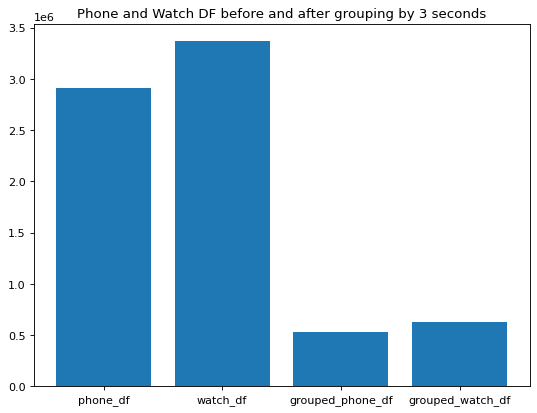

In [8]:
plt.figure(figsize=(8, 6), dpi=80)
plt.bar(range(len(shape_ref)), list(shape_ref.values()), align='center')
plt.xticks(range(len(shape_ref)), list(shape_ref.keys()))
plt.title('Phone and Watch DF before and after grouping by 3 seconds')
plt.show()

### Cosine Feature Engineering

Using cosine similarity to create more columns

In [9]:
%%time
def cosine_calc(df, left_col, right_col, device, sensor):
    """
        Function that computes cosine features for dataframe
        
        Parameters
        ----------
        
        df: pandas.core.frame.DataFrame
            Pandas dataframe for feature creatuon
        
        left_col: str
            which col to be considered on the left ['x', 'y', 'z']
        
        device: str
            type of the device: ['phone', 'watch']

        sensor: str
            type of the sensor: ['accel', 'gyro']
            
    """

    left_col_den = (left_col + "2_" + device + "_" + sensor + "sum")
    right_col_den = (right_col + "2_" + device + "_" + sensor + "sum")
    
    numerator = df[left_col + right_col + "_" + device + "_" + sensor + "sum"]
    denominator = np.sqrt(df[left_col_den] * df[right_col_den])
    
    cos = numerator / denominator
    
    return cos.fillna(0)


# phone accel
grouped_phone_df['cos_xy_phone_accel'] = cosine_calc(grouped_phone_df, 'x', 'y', 'phone', 'accel')
grouped_phone_df['cos_xz_phone_accel'] = cosine_calc(grouped_phone_df, 'x', 'z', 'phone', 'accel')
grouped_phone_df['cos_yz_phone_accel'] = cosine_calc(grouped_phone_df, 'y', 'z', 'phone', 'accel')
# phone gyro
grouped_phone_df['cos_xy_phone_gyro'] = cosine_calc(grouped_phone_df, 'x', 'y', 'phone', 'gyro')
grouped_phone_df['cos_xz_phone_gyro'] = cosine_calc(grouped_phone_df, 'x', 'z', 'phone', 'gyro')
grouped_phone_df['cos_yz_phone_gyro'] = cosine_calc(grouped_phone_df, 'y', 'z', 'phone', 'gyro')

# watch accel
grouped_watch_df['cos_xy_watch_accel'] = cosine_calc(grouped_watch_df, 'x', 'y', 'watch', 'accel')
grouped_watch_df['cos_xz_watch_accel'] = cosine_calc(grouped_watch_df, 'x', 'z', 'watch', 'accel')
grouped_watch_df['cos_yz_watch_accel'] = cosine_calc(grouped_watch_df, 'y', 'z', 'watch', 'accel')
# watch gyro
grouped_watch_df['cos_xy_watch_gyro'] = cosine_calc(grouped_watch_df, 'x', 'y', 'watch', 'gyro')
grouped_watch_df['cos_xz_watch_gyro'] = cosine_calc(grouped_watch_df, 'x', 'z', 'watch', 'gyro')
grouped_watch_df['cos_yz_watch_gyro'] = cosine_calc(grouped_watch_df, 'y', 'z', 'watch', 'gyro')

CPU times: user 47 ms, sys: 2.44 ms, total: 49.4 ms
Wall time: 47.9 ms


### CSV generation for reuse on EDA, Model tuning


In [10]:
drop_cols = [
    'subject_id', 'timestampmean', 'timestampsum',
]

os.makedirs('data/csv', exist_ok=True) 

grouped_phone_df.drop(columns=drop_cols).to_csv('data/csv/grouped_phone.csv')
grouped_watch_df.drop(columns=drop_cols).to_csv('data/csv/grouped_watch.csv')